# Clustering Settings

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

#시드 고정
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

In [ ]:
# 모델 이름을 작성합니다.
model_name = ''
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# 불러올 학습데이터 csv파일명을 작성합니다.
data = pd.read_csv(os.path.join(DATA_DIR, ''))
dataset_train, dataset_valid = train_test_split(data, test_size=0.3, stratify=data['target'],random_state=SEED)

In [29]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        labels = data['target']
        self.inputs = []
        self.labels = []
        
        for text, label in zip(input_texts, labels):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),  
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }
    
    def __len__(self):
        return len(self.labels)

# 1. Embedding

In [4]:
!pip install matplotlib

In [30]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7,output_hidden_states=True).to(DEVICE)
data_all = BERTDataset(data, tokenizer)

In [32]:
# 테스트
inputs = tokenizer(data.iloc[5]['text'],return_tensors='pt').to(DEVICE)
model(inputs['input_ids'])[1][-1].squeeze()[0]

tensor([ 1.1547e-01, -1.3712e-01,  8.0007e-01,  1.0557e+00,  6.2238e-01,
         2.0675e-01,  4.4641e-01,  1.4429e+00,  2.7431e-01, -8.5607e-01,
        -2.2786e+00, -4.1636e-01,  6.1140e-02,  1.3130e-01,  2.4217e+00,
        -2.3118e-01,  8.8832e-01, -1.8390e+00, -3.5575e-02, -6.2187e-01,
        -9.9113e-01, -1.7353e+00,  4.8890e-01,  1.7356e+00,  3.6059e-01,
        -2.8810e-02,  6.6870e-02, -1.2029e+00, -1.1742e+00, -1.5749e-01,
         7.5557e-01, -1.3750e-01,  5.8415e-01,  2.1066e-01,  3.0942e-01,
        -8.6723e-01, -1.4519e+00,  6.0319e-01, -3.3561e-01,  4.1488e-01,
        -7.1601e-01,  1.3344e+00, -2.9126e-01,  6.6624e-01, -1.7782e+00,
         6.8788e-01,  4.2582e-01, -6.6636e-01,  2.0516e-01, -1.7318e-01,
         7.8901e-01, -8.6296e-01, -4.9280e-01,  1.6541e+00,  9.8634e-01,
        -9.3710e-01, -2.8793e-02, -1.0273e+00, -2.1632e+00, -1.2639e-01,
        -3.8897e-01,  8.4558e-02,  1.0310e+00, -3.5978e-02, -3.1339e-01,
        -1.6916e-01, -1.9371e-01, -4.3604e-01,  4.3

In [8]:
# 모델 평가
preds = []
embedding = []
for idx, sample in tqdm(data.iterrows()):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        embedding.append(model(inputs['input_ids'])[1][-1].squeeze()[0].cpu())

15780it [03:45, 70.02it/s]


In [33]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 테스트 입력
inputs = tokenizer(data.iloc[5]['text'], return_tensors='pt').to(DEVICE)

# 모델을 평가 모드로 설정
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # 숨겨진 상태의 튜플
    last_hidden_state = hidden_states[-1]  # 마지막 레이어의 숨겨진 상태
    # [CLS] 토큰의 임베딩 추출
    cls_embedding = last_hidden_state[:, 0, :].squeeze().cpu()
    print(cls_embedding.shape)  # [hidden_size] 여야 함

# 데이터를 반복하여 임베딩 가져오기
embedding = []
model.eval()
for idx, sample in tqdm(data.iterrows(), total=len(data)):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]
        cls_embedding = last_hidden_state[:, 0, :].squeeze().cpu()
        embedding.append(cls_embedding)

torch.Size([768])


  0%|          | 0/15780 [00:00<?, ?it/s]

100%|██████████| 15780/15780 [03:47<00:00, 69.48it/s]


In [34]:
df_embedding = pd.DataFrame(embedding)
df_embedding['label'] = data['target']

In [35]:
df = df_embedding.iloc[:,:-1].applymap(lambda x: x.item())
df['label'] = [int(x) for x in df_embedding['label']]

/tmp/ipykernel_1173616/1946846411.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df_embedding.iloc[:,:-1].applymap(lambda x: x.item())


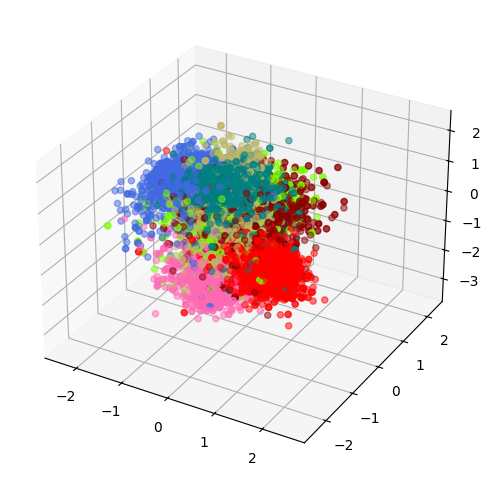

In [37]:
def plot_scatter3D(dataframe, sampling=10_000, save=False, fname='scatter_plot'):
    color_map = ['#8B0000', '#FF0000', '#BDB76B', '#7CFC00', '#008080', '#4169E1', '#FF69B4']
    if sampling:
        idx = np.random.randint(0, len(dataframe), sampling)    
        samples = dataframe.iloc[idx]
    else:
        samples = dataframe.copy()
    
    x = samples.iloc[:, 0]
    y = samples.iloc[:, 1]
    z = samples.iloc[:, 2]
    label = samples.loc[:, 'label']
    
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, color=label.apply(lambda x: color_map[x]), alpha=0.5)
    
    if save:
        plt.savefig(os.path.join(FIG_DIR, f'{fname}.png'), dpi=200)
    plt.show()

    
plot_scatter3D(df)

# 2. T-SNE

고차원 데이터를 시각화하기 위한 비지도 학습 기법. 데이터를 2차원 또는 3차원 공간으로 투영하여 시각적으로 클러스터를 탐색

In [13]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[ 2.9220085 63.551422 ]


/tmp/ipykernel_1173616/1643239131.py:17: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)


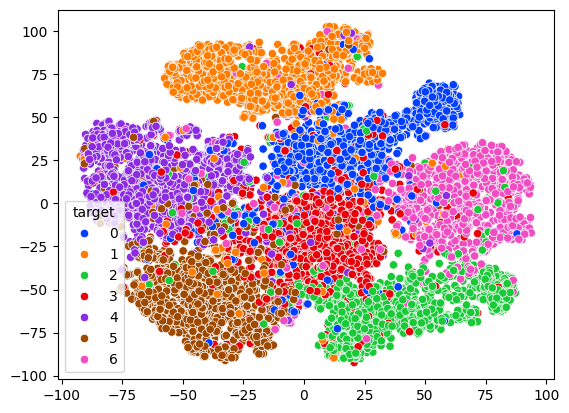

In [36]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components)
# data를 가지고 TSNE 모델을 훈련(적용) 합니다.
X_embedded = model.fit_transform(df.iloc[:,:-1])
# 훈련된(차원 축소된) 데이터의 첫번째 값을 출력해 봅니다. 
print(X_embedded[0])
# [57.53654     0.72270477]

# 차원 축소된 데이터를 그래프로 만들어서 화면에 출력해 봅니다.
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=data.target, legend='full', palette=palette)
plt.show()

# 3. Gaussian Mixture Model

데이터를 클러스터링하거나 밀도를 추정

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings

In [ ]:
import numpy as np
# Clustering 데이터 생성을 위해
from sklearn.datasets import make_blobs 
from sklearn.mixture import GaussianMixture

df_embedded = pd.DataFrame(X_embedded)


X, y = df_embedded, data['target']

gmm = GaussianMixture(n_components=7, random_state=42, max_iter=300)
gmm.fit(X)

gmm.means_ #gmm의 mean 값들을 확인 가능
gmm.weights_ #gmm의 weight 값들을 확인 가능
gmm.covariances_ #gmm의 공분산 행렬 확인 가능

gmm.predict(X) #각 point가 어느 Cluster에 포함되는지 결과를 확인
gmm.predict_proba(X) #각 point가 각 Cluster에 포함될 확률 (point 당 n_components개 만큼)

array([[2.08804683e-02, 4.16439718e-19, 5.99993016e-01, ...,
        8.36391427e-06, 8.21603765e-34, 3.79118150e-01],
       [7.48505478e-02, 1.49451961e-13, 1.23265296e-06, ...,
        3.28163465e-05, 3.82273116e-16, 9.25047237e-01],
       [1.34266959e-03, 1.11599918e-06, 4.94483267e-21, ...,
        1.56810349e-04, 7.83804958e-04, 9.96445123e-01],
       ...,
       [6.98654251e-06, 6.74219459e-06, 7.67120911e-41, ...,
        2.22888231e-07, 9.49820341e-01, 4.49962083e-02],
       [1.02964863e-17, 9.69788238e-01, 9.14843404e-48, ...,
        3.60784810e-05, 8.86409470e-03, 2.13115886e-02],
       [1.10840915e-04, 3.20540723e-17, 9.44700813e-01, ...,
        2.23223767e-04, 1.11798037e-40, 5.49651221e-02]])

In [40]:
pred = pd.DataFrame(gmm.predict(X))
X = pd.DataFrame(X)
y = pd.DataFrame(y)

final = pd.concat([X,y,pred],axis=1)
final.columns = ['vec1', 'vec2', 'target', 'pred']

/tmp/ipykernel_1173616/3892694249.py:4: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)
/tmp/ipykernel_1173616/3892694249.py:6: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)


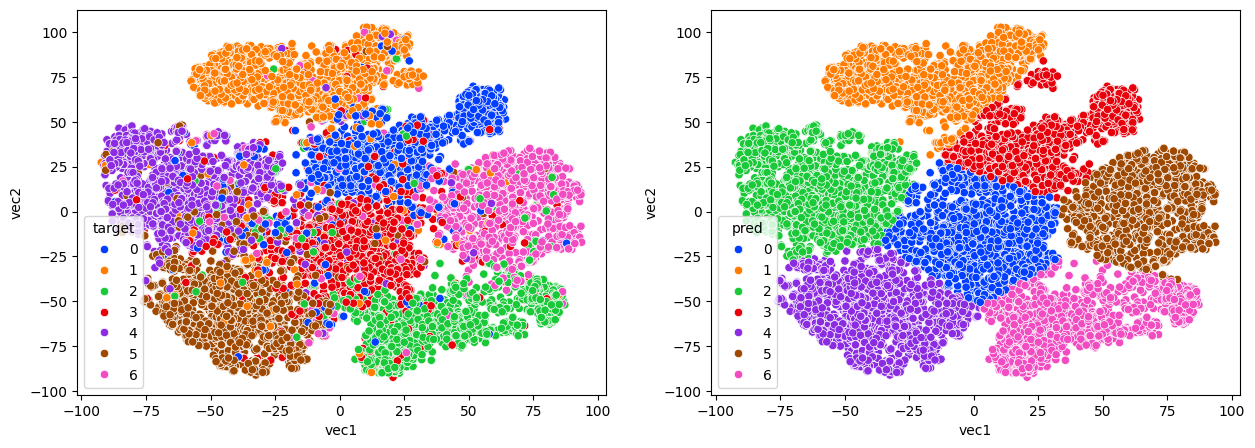

In [53]:
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)
plt.subplot(1, 2, 2)
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)
plt.show()

In [61]:
cluster_labels = final.groupby('pred')['target'].agg(lambda x: x.value_counts().index[0])
pred_dic = cluster_labels.to_dict()
final['pred'] = final['pred'].map(pred_dic)

# 예측 결과와 실제 레이블이 일치하지 않는 인덱스 확인하기
changed = final[final['target'] != final['pred']].index.tolist()
print(len(changed))

2193


/tmp/ipykernel_1173616/4051284451.py:1: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)


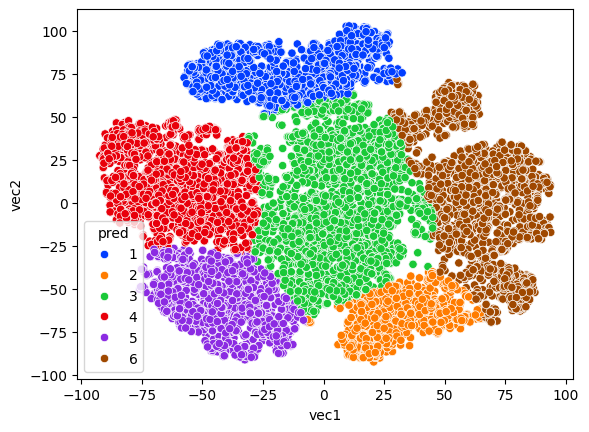

In [44]:
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)
plt.show()

In [45]:
final_df = pd.concat([final, data[['ID','text']]],axis=1)
final_df = final_df[['ID', 'text', 'pred']]
final_df.columns = ['ID', 'text', 'target']

# 4. K-Means

주어진 데이터셋을 K개의 클러스터로 나누는 방법

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings

In [ ]:
import numpy as np

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import warnings

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

In [48]:
df_embedded = pd.DataFrame(X_embedded)
X, y = df_embedded, data['target']


kmeans = KMeans(n_clusters=7, random_state=SEED, n_init=300, max_iter=300)
kmeans.fit(X)

KMeans(n_clusters=7, n_init=300, random_state=2024)

In [50]:
pred = pd.DataFrame(kmeans.predict(X))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

final = pd.concat([X,y,pred],axis=1)
final.columns = ['vec1', 'vec2', 'target', 'pred']

/tmp/ipykernel_1173616/2763094007.py:4: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)
/tmp/ipykernel_1173616/2763094007.py:6: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)


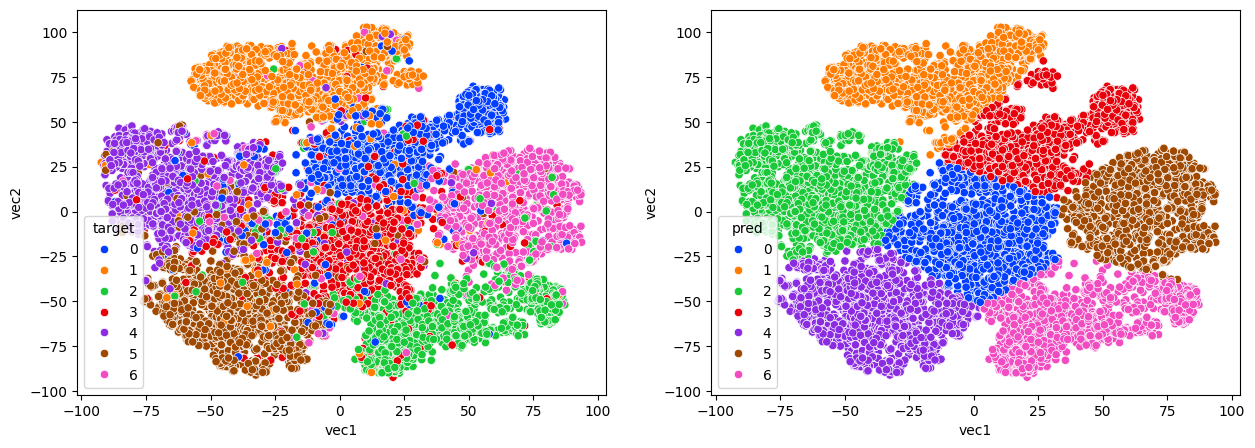

In [51]:
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['target'], legend='full', palette=palette)
plt.subplot(1, 2, 2)
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)

plt.show()

In [62]:
cluster_labels = final.groupby('pred')['target'].agg(lambda x: x.value_counts().index[0])
pred_dic = cluster_labels.to_dict()
final['pred'] = final['pred'].map(pred_dic)

# 예측 결과와 실제 레이블이 일치하지 않는 인덱스 확인하기
changed = final[final['target'] != final['pred']].index.tolist()
print(len(changed))

2193


/tmp/ipykernel_1173616/4051284451.py:1: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)


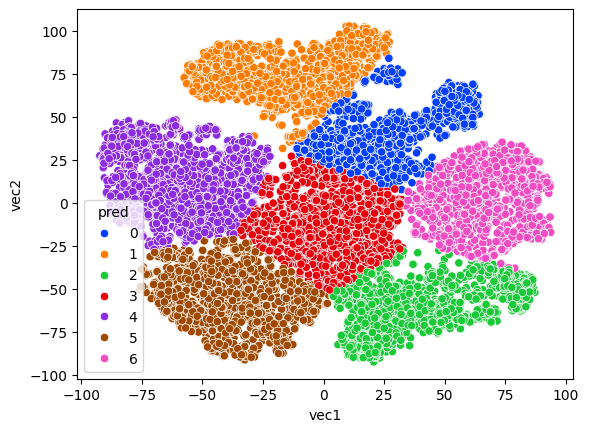

In [58]:
sns.scatterplot(x=final['vec1'], y=final['vec2'], hue=final['pred'], legend='full', palette=palette)
plt.show()

In [55]:
final_df = pd.concat([final, data[['ID','text']]],axis=1)
final_df = final_df[['ID', 'text', 'pred']]
final_df.columns = ['ID', 'text', 'target']

In [ ]:
final_df.to_csv(os.path.join(DATA_DIR,''))